## Ferraria Issue
Based on the paper, <br />

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

When faced with probabilistic data generated through samples, users may find it difficult to know which x-axis values are most likely to be representative, as the distributions of each category is different and confidence levels overlap. <br />
As such, it is proposed to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value. <br />
In order to make the visualisation more intuitive to users, it is proposed to incorporate interactivity to allow for users to choose the y-axis value of interest. <br />
The following is an attempt to solve the issue.



In [5]:
import pandas as pd
import numpy as np

np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])

info = df.T.describe()

In [6]:
from scipy.stats import sem, t
import scipy.stats as ss

y = 42000

def conf_int(data):
    confidence = 0.95

    n = len(data)
    m = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    start = m - h
    end = m + h
    return (start, end, h)

confidence_interval = [conf_int(y) for x,y in df.T.iteritems()]

def color_prob(y, interval):
    if y < interval[0]:
        return 1.0
    elif y > interval[1]:
        return 0.0
    else:
        return (interval[1] - y)/(interval[1]-interval[0])
    
color_probability = [color_prob(y,i) for i in confidence_interval]

C:\Users\alson\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  # This is added back by InteractiveShellApp.init_path()


In [7]:
import matplotlib.cm as cm
import matplotlib.colors as colors

cmap = cm.get_cmap('coolwarm')

df_color = pd.DataFrame(color_probability, columns = ['Probability'], index = [1992,1993,1994,1995])
df_color['Colors'] = [cmap(x) for x in df_color['Probability']]
df_color['h'] = [x[2] for x in confidence_interval]
df_color['mean'] = list(info.loc['mean'])

<IPython.core.display.Javascript object>


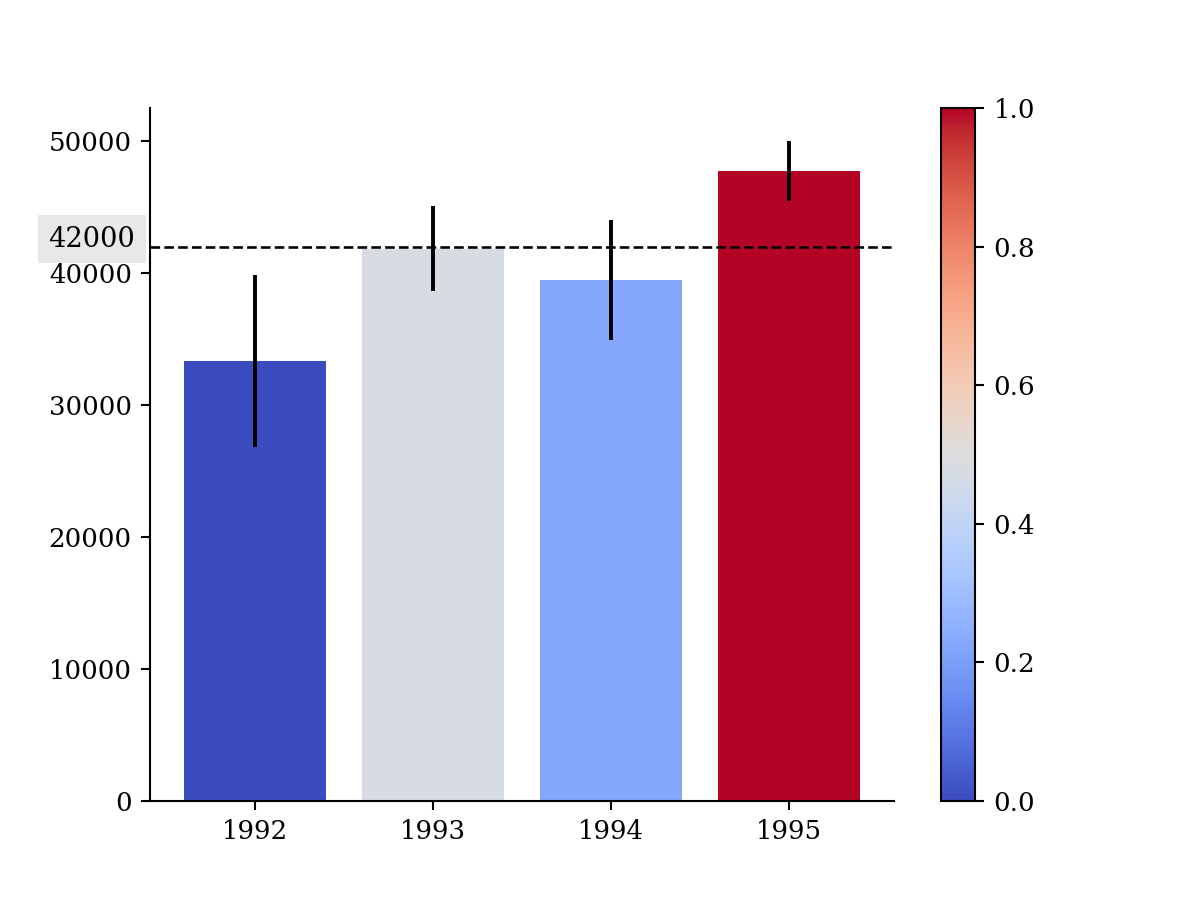

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt

#Plotting
plt.figure()
bar = plt.bar(df_color.index, height = df_color['mean'], yerr = df_color['h'], color=df_color['Colors'])

#Visual
plt.rc('font', family='serif')
plt.xticks(df_color.index, ('1992', '1993', '1994', '1995'))
line = plt.axhline(y=y, color='k', linewidth=1, linestyle='--')
text = plt.text(1990.84, y, '%d' %y, fontsize = 10.5, color = 'k', bbox=dict(facecolor='lightgrey', edgecolor='none', alpha = 0.5))
colorlegend = cm.ScalarMappable(cmap = cmap, norm = colors.Normalize(vmin=0, vmax=1.0))
colorlegend.set_array([])
cbar = plt.colorbar(colorlegend, orientation = 'vertical')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#Interactivity
def onclick(event):
    y = event.ydata
    new_color_probability = [color_prob(y,i) for i in confidence_interval]
    df_color['New Probability'] = new_color_probability
    df_color['New Colors'] = [cmap(x) for x in df_color['New Probability']]
    line.set_ydata(y)
    text.set_text('%d' %y)
    text.set_position((1990.84, y))
    for i in range(len(df_color)):
        bar[i].set_color(df_color.iloc[i,5])
    
    
plt.gcf().canvas.mpl_connect('button_press_event', onclick);